In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import json

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Activation, MultiHeadAttention
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

os.environ['CUDA_VISIBLE_DEVICES']='1'
tf.config.set_soft_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

1 Physical GPUs, 1 Logical GPUs
Version:  2.5.0
Eager mode:  True
GPU is available


# Constants

In [2]:
folder_name = '20210904_en_classification'

wv_dim = 32
que_pad = 300
num_words = 10000

# Load data

In [3]:
(decoder_train, class_train), (decoder_vali, class_vali) = imdb.load_data(
    num_words = num_words,
)
decoder_vali = decoder_vali[:2500]
class_vali = class_vali[:2500]

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/ai-lab/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/ai-lab/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do

In [4]:
decoder_train = sequence.pad_sequences(
    decoder_train,
    maxlen = que_pad,
)
decoder_vali = sequence.pad_sequences(
    decoder_vali,
    maxlen = que_pad,
)
print('decoder_train_shape:', decoder_train.shape)
print('decoder_test_shape:', decoder_vali.shape)

decoder_train_shape: (25000, 300)
decoder_test_shape: (2500, 300)


# Positional Encoding
[Positional Encoding](https://www.tensorflow.org/text/tutorials/transformer)
based on [Vaswani+17, Attention is All You Need](https://arxiv.org/abs/1706.03762)

In [5]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

## Test positional encoding

(1, 10, 64)


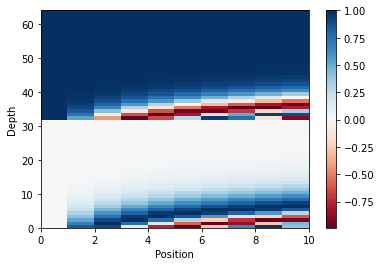

In [6]:
from matplotlib import pyplot as plt
n, d = 10, 64
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

# Embedding

In [7]:
def getEmb():
    initializer = tf.keras.initializers.GlorotNormal()
    mask_embedding = initializer(shape=(1, wv_dim)).numpy()
    emb = Embedding(
        num_words, 
        wv_dim, 
        mask_zero = False,
        input_length=(int(que_pad)),
        trainable = True,
    )
    return emb

# Generator

[OneHot relaxation](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/RelaxedOneHotCategorical)
based on [Jang+16](https://arxiv.org/abs/1611.01144) and [Maddison+16](https://arxiv.org/abs/1611.00712) 
<br>
[Multi-Head Attention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention) 
and [Positional Encoding](https://www.tensorflow.org/text/tutorials/transformer)
based on [Vaswani+17, Attention is All You Need](https://arxiv.org/abs/1706.03762)

In [8]:
def Transformer(que_pad, wv_dim, mask = None, rate = 0.1):
    # Inputs
    mem  = Input((que_pad, wv_dim))
    # Constants
    ff_dim = wv_dim*16
    # Multi-Head Attention
    # TODO: concatenation
    q = Dense(wv_dim)(mem)
    k = Dense(wv_dim)(mem)
    v = Dense(wv_dim)(mem)
    #print(mask)
    mem_new = MultiHeadAttention(
        num_heads = 4,
        key_dim = wv_dim, 
        value_dim = wv_dim
    )(
        q, k, v,
        attention_mask = mask,
    )
    #mem_new = Dropout(rate)(mem_new)
    mem_new = LayerNormalization(epsilon=1e-6)(mem_new+mem)
    # Feed-Forward skip-connection
    ffn = Dense(ff_dim, activation = 'relu')(mem_new)
    ffn = Dense(wv_dim)(ffn)
    #ffn = Dropout(rate)(ffn)
    out = LayerNormalization(epsilon=1e-6)(ffn+mem_new)
    model = Model(
        mem,
        [mem_new, out]
    )
    return model

# GPT downstream
def getG(emb):
    _input = Input((que_pad,))
    mem = emb(_input)
    # position encoding
    pe = positional_encoding(que_pad, wv_dim)
    mem = LayerNormalization(epsilon=1e-6)(mem+pe)
    #mask = np.tri(que_pad, que_pad, 0) # (q_dim, k_dim)
    mask = np.ones((que_pad, que_pad)) # (q_dim, k_dim)
    # forward sentence
    for i in range(1):
        tLayer = Transformer(que_pad, wv_dim, mask)
        mem, output = tLayer((mem))
        output = Activation('relu')(output)
        mem = Activation('relu')(mem)
    # Take the first token as output
    token, *_ = tf.split(output, num_or_size_splits=que_pad, axis=1)
    print(token.shape)
    token = tf.squeeze(token, axis = 1)
    print(token.shape)
    token = Dense(1)(token)
    token = Activation('sigmoid')(token)
    model = Model(
        _input, 
        token,
        name = 'GPT'
    ) 
    return model

In [9]:
emb = getEmb()
mleG=getG(emb)
mleG.compile(
    loss='binary_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy'],
)
mleG.summary()

(None, 1, 32)
(None, 32)
Model: "GPT"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 32)           320000    
_________________________________________________________________
tf.__operators__.add (TFOpLa (None, 300, 32)           0         
_________________________________________________________________
layer_normalization (LayerNo (None, 300, 32)           64        
_________________________________________________________________
model (Functional)           [(None, 300, 32), (None,  53408     
_________________________________________________________________
activation (Activation)      (None, 300, 32)           0         
_________________________________________________________________
tf.split (TFOpLambda)        [(None, 1

In [10]:
mleG.fit(
    decoder_train, class_train, 
    batch_size=32, 
    epochs=300, 
    shuffle=True, 
    validation_data = (decoder_vali, class_vali), 
    callbacks=[
        ModelCheckpoint(
            f'./{folder_name}/mleG.h5', 
            save_best_only=True, 
            monitor = "val_loss"
        ),
        EarlyStopping(monitor='val_loss', patience=5),
        CSVLogger(f'{folder_name}/mleG.csv'),
    ]
)

Epoch 1/300
782/782 [==============================] - 18s 20ms/step - loss: 0.5572 - accuracy: 0.6610 - val_loss: 0.2989 - val_accuracy: 0.8808
Epoch 2/300
782/782 [==============================] - 16s 20ms/step - loss: 0.2579 - accuracy: 0.8960 - val_loss: 0.2753 - val_accuracy: 0.8872
Epoch 3/300
782/782 [==============================] - 16s 21ms/step - loss: 0.1803 - accuracy: 0.9318 - val_loss: 0.3049 - val_accuracy: 0.8780
Epoch 4/300
782/782 [==============================] - 16s 20ms/step - loss: 0.1410 - accuracy: 0.9500 - val_loss: 0.3686 - val_accuracy: 0.8656
Epoch 5/300
782/782 [==============================] - 16s 20ms/step - loss: 0.1017 - accuracy: 0.9660 - val_loss: 0.3907 - val_accuracy: 0.8668
Epoch 6/300
782/782 [==============================] - 16s 20ms/step - loss: 0.0819 - accuracy: 0.9731 - val_loss: 0.4665 - val_accuracy: 0.8520
Epoch 7/300
782/782 [==============================] - 16s 20ms/step - loss: 0.0625 - accuracy: 0.9806 - val_loss: 0.5536 - val_ac

No handles with labels found to put in legend.


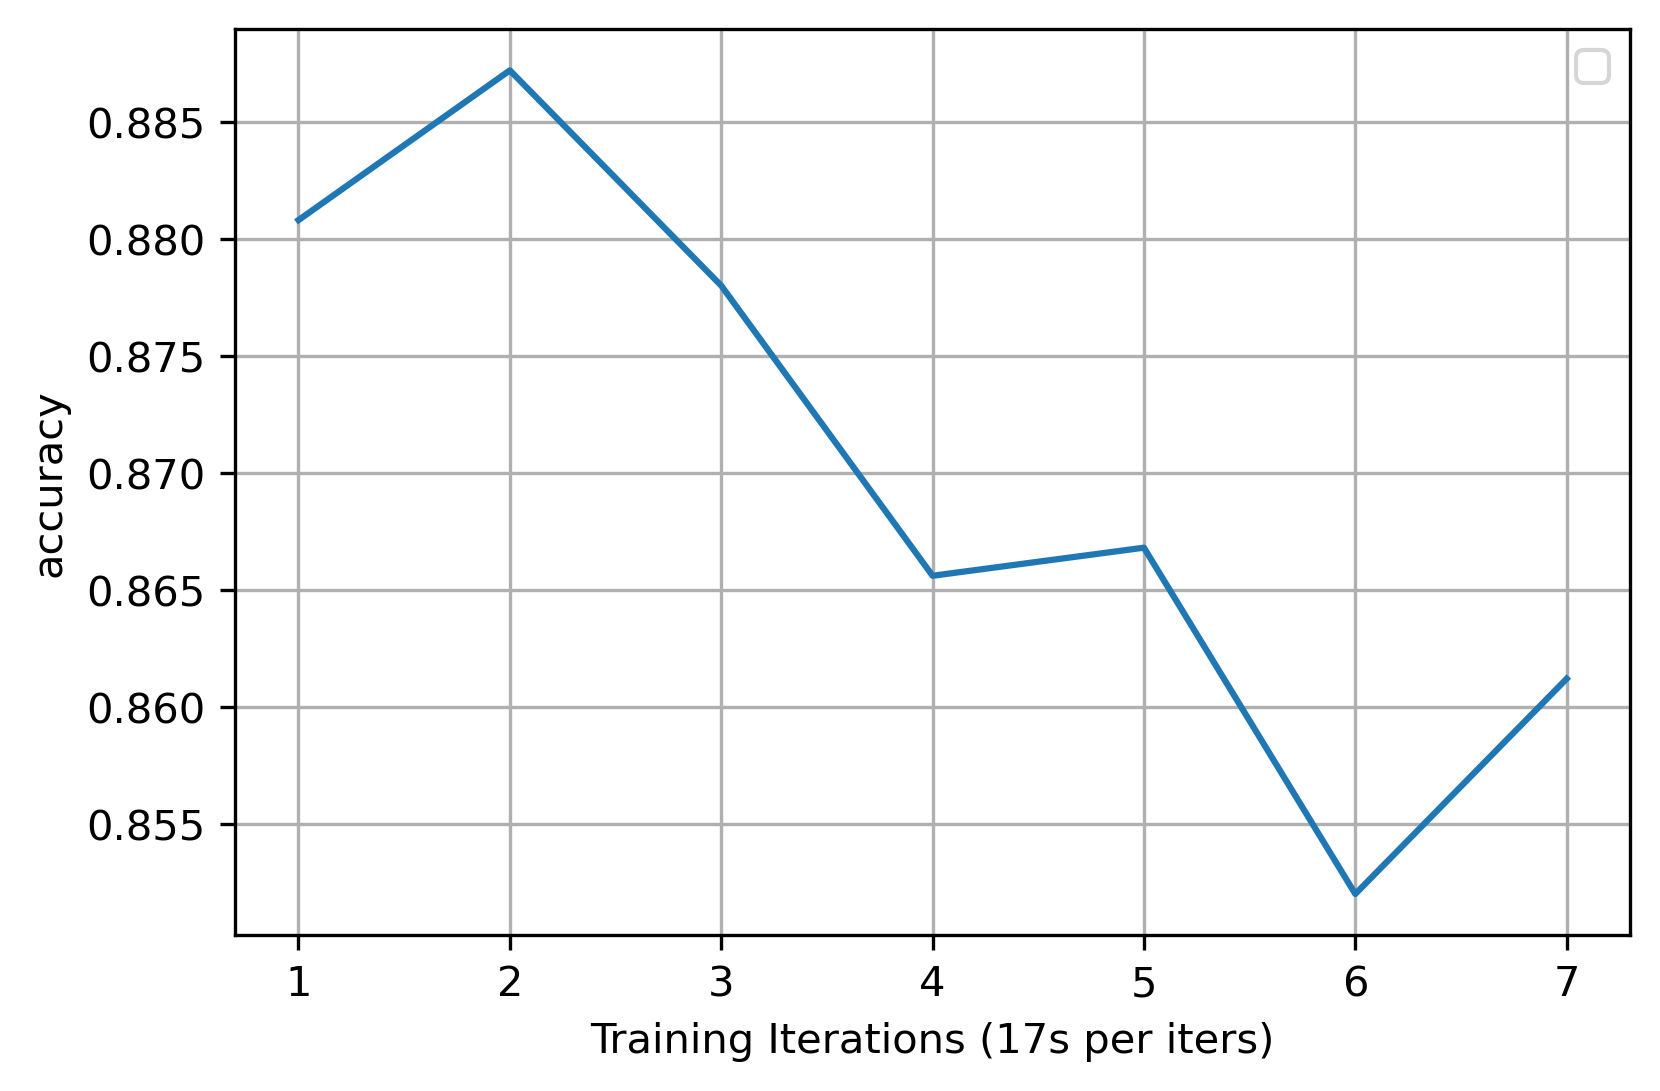

In [17]:
import csv
from matplotlib import pyplot as plt
%matplotlib inline
rows = csv.reader(open(f'{folder_name}/mleG.csv'))
nll_mle = []
for i, row in enumerate(rows):
    if i == 0:
        continue
    nll_mle.append(float(row[-2]))
plt.figure(dpi = 300)
plt.plot(np.arange(1,len(nll_mle)+1), nll_mle)
plt.grid(True)
plt.ylabel(r'accuracy')
plt.xlabel('Training Iterations (17s per iters)')
plt.legend()
plt.show()

In [12]:
np.savetxt(f'{folder_name}/mleG_nll_list.txt', nll_mle)